# Odnoklassniki data 

In [342]:
import pandas as pd

df = pd.read_csv('ok_weather.csv.gz', compression='gzip')

In [344]:
print('Posts:', len(df))
print('Unique users:', len(df['userId'].unique()))
print('Posts per user:', len(df)/len(df['userId'].unique()))

Posts: 8601737
Unique users: 3310639
Posts per user: 2.598210496523481


In [345]:
from collections import Counter
import numpy as np

def aggregated_sentiment(x):
    ordered = Counter(x).most_common()
    if len(ordered) == 1:
        return ordered[0][0]
    elif ordered[0][1]>ordered[1][1]:
        return ordered[0][0]
    return np.nan

    
def aggregate_sentiment_per_user(df):
    result = df.groupby(['userId', 'date'])['sentiment'].agg([aggregated_sentiment])
    user_to_sentiment = {}
    for i in tqdm(range(len(result))):
        user_to_sentiment[result.index[i]] = result['aggregated_sentiment'].values[i]         
    df['sentiment'] = [user_to_sentiment[(df['userId'].values[i], df['date'].values[i])] for i in tqdm(range(len(df)))]
    df = df.dropna(subset=['sentiment'])
    df = df.drop_duplicates(subset=['userId', 'date'])
    return df

In [346]:
df = aggregate_sentiment_per_user(df)
df = df.reset_index()

100%|██████████| 8601737/8601737 [01:02<00:00, 137850.97it/s]


In [347]:
print('Posts after aggregation:', len(df))

Posts after aggregation: 8348908


# Weather data

## Load data from Meteostat

In [348]:
from datetime import timedelta

dt_objects_with_timezone = pd.to_datetime(df['dt_object_with_timezone'])
df_unique_lat_lng = df.drop_duplicates(subset=['lat', 'lng'])
start_date = min(dt_objects_with_timezone) - timedelta(days = 30)
end_date = max(dt_objects_with_timezone) + timedelta(days = 30)

In [349]:
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Hourly
from tqdm import tqdm
import os
from os.path import exists

def get_weather_file_name(lat, lng):
    return 'lat='+str(lat)+"_lng="+str(lng)
    
def download_weather_data(lats, lngs, start_date, end_date, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in tqdm(range(len(lats))):
        location = Point(lats[i], lngs[i])
        data = Daily(location, start_date, end_date)
        data = data.fetch()
        data.to_csv(directory+'/' + get_weather_file_name(lats[i], lngs[i]) + '.csv')
        
def load_weather_data_from_disk(lats, lngs, directory):
    weather_cache = {}
    for i in tqdm(range(len(lats))):
        lat = lats[i]
        lng = lngs[i]
        name = directory+'/' + get_weather_file_name(lats[i], lngs[i]) + '.csv' 
        if exists(name):
            df_weather = pd.read_csv(name, index_col=0)
            for weather_index, weather_row in df_weather.iterrows():
                cache_name = 'lat='+str(lat)+"_lng="+str(lng)+'_ydm='+weather_index
                weather_cache[cache_name]=weather_row.to_dict()
    return weather_cache
    

#download_weather_data(df_unique_lat_lng['lat'].values, df_unique_lat_lng['lng'].values, 
#                      start_date, end_date, 'weather_data_daily_ok')
weather_cache = load_weather_data_from_disk(df_unique_lat_lng['lat'].values, df_unique_lat_lng['lng'].values, 
                                           'weather_data_daily_ok')

100%|██████████| 5286/5286 [04:06<00:00, 21.42it/s]


In [350]:
lats = df['lat'].values
lngs = df['lng'].values

In [351]:
from tqdm import tqdm
from datetime import datetime

weather_items = []

for i in tqdm(range(len(lats))):
    cache_name = 'lat='+str(lats[i])+"_lng="+str(lngs[i])+'_ydm='+dt_objects_with_timezone[i].strftime('%Y-%m-%d')
    if cache_name in weather_cache:
        value = weather_cache[cache_name]
        if value:
            weather_items.append(weather_cache[cache_name])
        else:
            weather_items.append(None)   
    else:
        weather_items.append(None)   

100%|██████████| 8348908/8348908 [02:28<00:00, 56129.38it/s]


In [352]:
previous_day_weatheer_items = []

for i in tqdm(range(len(dt_objects_with_timezone))):
    previous_day = dt_objects_with_timezone[i] - timedelta(days = 1)
    cache_name = 'lat='+str(lats[i])+"_lng="+str(lngs[i])+'_ydm='+previous_day.strftime('%Y-%m-%d')
    if cache_name in weather_cache:
        value = weather_cache[cache_name]
        if value:
            previous_day_weatheer_items.append(weather_cache[cache_name])
        else:
            previous_day_weatheer_items.append(None)   
    else:
        previous_day_weatheer_items.append(None)   

100%|██████████| 8348908/8348908 [03:09<00:00, 43966.32it/s]


In [353]:
df['weather'] = weather_items
df['weather_previous_day'] = previous_day_weatheer_items

In [354]:
df_weather = df.dropna(subset=['weather', 'weather_previous_day'])

In [355]:
df_weather['tavg'] = [float(w['tavg']) for w in df_weather['weather']] 
df_weather['tmin'] = [float(w['tmin']) for w in df_weather['weather']] 
df_weather['tmax'] = [float(w['tmax']) for w in df_weather['weather']]  
df_weather['wspd'] = [float(w['wspd']) for w in df_weather['weather']] 
df_weather['tavg_previous_day'] = [float(w['tavg']) for w in df_weather['weather_previous_day']] 

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [356]:
df_weather = df_weather.dropna(subset=['tavg', 'tmin', 'tmax', 'wspd', 'tavg_previous_day'])

# Extract city from Odnoklassniki data

In [357]:
df_weather['lat_lng'] = [str(df_weather['lat'].values[i])+'_'+str(df_weather['lng'].values[i]) for i in tqdm(range(len(df_weather)))]

100%|██████████| 6451550/6451550 [01:04<00:00, 100425.28it/s]


In [358]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapiExercises")

custom_city_mapper = {}

for lat_lng in tqdm(df_weather[df_weather['city'].isna()]['lat_lng'].unique()):
    location = geolocator.reverse(lat_lng.replace('_', ','), language='en')
    city = location.raw.get('address').get('city')
    if city:
        # Fix inconsistency between Odnoklassniki and Nominatum notations
        if city == 'Korolyov':
            city = 'Korolev'
        elif city == 'Perm District':
            city = 'Perm'
        elif city == 'Oryol':
            city = 'Orel'
        elif city == 'Nizhny Novgorod':
            city = 'Nizhni Novgorod'
        custom_city_mapper[lat_lng] = city

100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


In [359]:
def extract_city(row):
    if row['city'] is not None:
        return row['city']
    if row['lat_lng'] in custom_city_mapper:
        return custom_city_mapper['lat_lng']
    return None
df_weather['city_extended'] = [extract_city(row) for _, row in tqdm(df_weather.iterrows())]

6451550it [06:01, 17831.93it/s]


In [360]:
df_weather = df_weather.dropna(subset=['city_extended'])

# Encode Entities

In [362]:
from sklearn import preprocessing
le3 = preprocessing.LabelEncoder()
le3.fit(df_weather['city_extended'])

df_weather['city_int'] = le3.transform(df_weather['city_extended'])

In [363]:
def positive_count(series):
    return sum(series == 'positive')

def count(series):
    return len(series)

df_ru_sample_agg = df_weather.groupby(['date', 'city_int']).agg({
    'tavg': ['mean'],
    'tavg_previous_day': ['mean'],
    'tmin': ['mean'],
    'tmax': ['mean'],
    'wspd':  ['mean'],
    'sentiment': [positive_count, count]
})

100%|██████████| 500/500 [00:10<00:00, 49.02it/s]


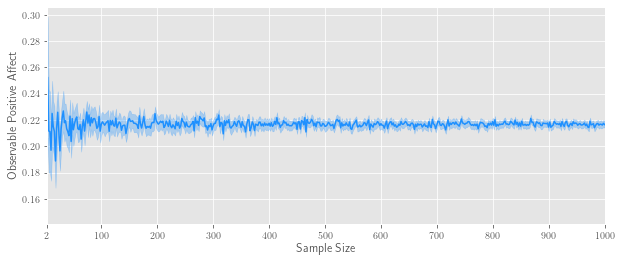

In [364]:
import random
import scipy.stats as st
from matplotlib import pyplot as plt
from collections import Counter
import matplotlib.ticker as mtick
from matplotlib.dates import MonthLocator, DateFormatter
%matplotlib inline

expressed_sentiment = df['sentiment'].values
arrays = []

x = list(range(2, 1001, 2))
for i in tqdm(x):
    arr = []
    for j in range(100):
        s = random.choices(expressed_sentiment, k=i)
        arr.append(s.count('positive')/i)
    arrays.append(arr)     
    
conf_intervals = np.array([st.t.interval(alpha=0.95, df=len(a)-1, loc=np.mean(a), scale=st.sem(a)) for a in arrays])

plt.style.use('ggplot')

fig = plt.gcf()
fig.set_size_inches(10, 4)

plt.plot(x, conf_intervals.mean(axis=1), color='dodgerblue')

plt.fill_between(x, conf_intervals[:,0], conf_intervals[:,1], color='dodgerblue', alpha=0.3)
plt.xlim(min(x), max(x))
ticks = np.arange(0, max(x)+1, 100)
ticks[0]=2
plt.xticks(ticks)
plt.xlabel('Sample Size')
plt.ylabel('Observable Positive Affect')
plt.show()
fig.savefig('oswb_pa_sample_size.png', dpi=180, bbox_inches='tight')

In [365]:
import numpy as np

def get_wind_speed_interval(ws):
    if ws == 0:
        return 'None'
    elif ws < 2:
        return 'Calm (<2 km/h)'
    elif ws <5:
        return 'Light air (<5 km/h)' 
    elif ws <11:
        return 'Light breeze (<11 km/h)' 
    elif ws <19:
        return 'Gentle breeze (<19 km/h)' 
    elif ws <29:
        return 'Moderate breeze (<28 km/h)'
    elif ws < 38:
        return 'Fresh breeze (<38 km/h)'
    else:
        return None
    
def get_prcp_interval(t):
    bins = [i for i in range(0, 20, 1)]
    bins.append(500)
    index = np.digitize([t], bins)[0]
    return '['+str(bins[index-1])+', '+str(bins[index])+')'

def get_temp_interval(t):
    if t == 0:
        return 't=0'
    elif t > 0:
        if t <= 5:
            return "0 < t <= 5"
        elif t <= 10:
            return "5 < t <= 10"
        elif t <= 15:
            return "10 < t <= 15"
        elif t <= 20:
            return "15 < t <= 20"
        elif t <= 25:
            return "20 < t <= 25"
        else:
            return "t > 25"
    else:
        if t>=-5:
            return "-5 =< t < 0" 
        elif t>=-10:
            return "-10 =< t < -5" 
        elif t>=-15:
            return "-15 =< t < -10" 
        elif t>=-20:
            return "-20 =< t < -15" 
        elif t>=-25:
            return "-25 =< t < -20" 
        else:
            return "t < -25" 

In [366]:
def select_cities(df, n):
    c = Counter(df.index.get_level_values(1))
    cities = []
    for city_int, number in c.items():
        if number>=n:
            cities.append(city_int)
    return cities

In [502]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from datetime import datetime
import warnings

warnings.filterwarnings('always')

df_ru_sample_agg_50 = df_ru_sample_agg[df_ru_sample_agg[('sentiment', 'count')]>=300]
df_ru_sample_agg_50 = df_ru_sample_agg_50[df_ru_sample_agg_50.index.get_level_values(1)
                                          .isin(select_cities(df_ru_sample_agg_50, 60))]

agg_dates = [datetime.strptime(df_ru_sample_agg_50.index.get_level_values(0)[i], '%Y-%m-%d') for i in range(len(df_ru_sample_agg_50))]
df_ru_sample_agg_50['weekday'] = [d.weekday() for d in agg_dates]
df_ru_sample_agg_50['month'] = [d.strftime("%B") for d in agg_dates]
df_ru_sample_agg_50['season'] = [d.month%12 // 3 + 1 for d in agg_dates]

df_ru_sample_agg_50['below_avg'] = abs(df_ru_sample_agg_50[('tavg',  'mean')]-df_ru_sample_agg_50[('tmin',  'mean')])
df_ru_sample_agg_50['above_avg'] = abs(df_ru_sample_agg_50[('tmax',  'mean')]-df_ru_sample_agg_50[('tavg',  'mean')])
df_ru_sample_agg_50['max_diff'] = [max(df_ru_sample_agg_50['below_avg'].values[i], 
                                       df_ru_sample_agg_50['above_avg'].values[i]) for i in range(len(df_ru_sample_agg_50))]


df_ru_sample_agg_50['temp_diff'] = df_ru_sample_agg_50[('tmax',  'mean')]-df_ru_sample_agg_50[('tmin',  'mean')]
df_ru_sample_agg_50['tavg_day_diff'] = df_ru_sample_agg_50[('tavg',  'mean')]-df_ru_sample_agg_50[('tavg_previous_day',  'mean')]

df_ru_sample_agg_50['tavg_previous_day_bins'] = df_ru_sample_agg_50[('tavg_day_diff',  '')].apply(lambda x: get_temp_interval(x))
df_ru_sample_agg_50['tmax_bins'] = df_ru_sample_agg_50[('tmax',  'mean')].apply(lambda x: get_temp_interval(x))
df_ru_sample_agg_50['max_diff_bins'] = df_ru_sample_agg_50[('max_diff',  '')].apply(lambda x: get_temp_interval(x))
df_ru_sample_agg_50['wspd_bins'] = df_ru_sample_agg_50[('wspd',  'mean')].apply(lambda x: get_wind_speed_interval(x))

wspd_range = pd.get_dummies(df_ru_sample_agg_50['wspd_bins'], prefix='wspd')
dummy_min_max_range = pd.get_dummies(df_ru_sample_agg_50['max_diff_bins'], prefix='temp_diff_during_day_interval')
dummy_tmax = pd.get_dummies(df_ru_sample_agg_50['tmax_bins'], prefix='T^{Max}')
dummy_tavg_previous_day = pd.get_dummies(df_ru_sample_agg_50['tavg_previous_day_bins'], prefix='tavg_previous_day')

dummy_tmax = dummy_tmax.drop(columns=['T^{Max}_0 < t <= 5'])
dummy_min_max_range = dummy_min_max_range.drop(columns=['temp_diff_during_day_interval_0 < t <= 5'])
dummy_tavg_previous_day = dummy_tavg_previous_day.drop(columns=['tavg_previous_day_0 < t <= 5'])
wspd_range = wspd_range.drop(columns=['wspd_Gentle breeze (<19 km/h)'])

exog = sm.add_constant(pd.concat([dummy_tmax, dummy_min_max_range, dummy_tavg_previous_day, wspd_range], axis=1))
df_ru_sample_agg_50['y'] = df_ru_sample_agg_50[('sentiment', 'positive_count')]/df_ru_sample_agg_50[('sentiment', 'count')]
mod = PanelOLS(df_ru_sample_agg_50['y'],
               exog, entity_effects=True, time_effects=True)
fe_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      y   R-squared:                        0.0074
Estimator:                   PanelOLS   R-squared (Between):             -0.0111
No. Observations:                4349   R-squared (Within):               0.0186
Date:                Sun, Sep 11 2022   R-squared (Overall):              0.0003
Time:                        21:03:37   Log-likelihood                 1.141e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.8851
Entities:                         730   P-value                           0.6463
Avg Obs:                       5.9575   Distribution:                 F(30,3583)
Min Obs:                       3.0000                                           
Max Obs:                       7.0000   F-statistic (robust):          2.057e+14
                            

In [494]:
from collections import defaultdict 

def extract_unique_users():
    cities = [extract_city(row) for _, row in tqdm(df.iterrows())]
    cities_fast_mapper = {}
    known_cities = set(le3.classes_)

    for city in tqdm(set(cities)):
        if city in known_cities:
            cities_fast_mapper[city] = le3.transform([city])[0]
            
    counter = defaultdict(lambda: defaultdict(list))

    for i in tqdm(range(len(df))):
        if cities[i] in cities_fast_mapper:
            counter[df['date'].values[i]][cities_fast_mapper[cities[i]]].append(df['userId'].values[i])
            
    unique_users = list()
    temp_date_city_df = df_ru_sample_agg_50.reset_index()[['date', 'city_int']]
    for i in tqdm(range(len(temp_date_city_df))):
        unique_users.extend(counter[temp_date_city_df['date'].values[i]][temp_date_city_df['city_int'].values[i]])
    unique_users = set(unique_users)  
    return set(unique_users)


unique_users = extract_unique_users()

print('Posts:', sum(df_ru_sample_agg_50['sentiment', 'count']))
print('Users:', len(unique_users))
print('Posts per user:', sum(df_ru_sample_agg_50['sentiment', 'count'])/len(unique_users))

8348908it [07:33, 18415.01it/s]
100%|██████████| 4349/4349 [00:08<00:00, 495.26it/s]


Posts: 2764468
Users: 1312408
Posts per user: 2.1064089825724928


In [500]:
def get_ordered_list_of_cities():
    rrr = df_ru_sample_agg_50.copy().reset_index().groupby([('city_int', '')]).agg('sum')[('sentiment','count')]
    rrr = rrr.reset_index().sort_values(by=[('sentiment','count')],  ascending=False)['city_int']
    return ', '.join(le3.inverse_transform(rrr))
print('Cities:', get_ordered_list_of_cities())   

Cities: Moscow, Yekaterinburg, Krasnodar, Novosibirsk, Saint Petersburg, Samara, Rostov-na-donu


In [507]:
fgf = df_ru_sample_agg_50.copy().reset_index().groupby([('city_int', '')]).agg('sum')[('sentiment','count')].reset_index()
fgf['city'] = le3.inverse_transform(fgf['city_int'])
fgf

,city_int,sentiment,city
,,count,
0,463,376529,Krasnodar
1,623,1216691,Moscow
2,720,315368,Novosibirsk
3,892,125843,Rostov-na-donu
4,910,194508,Saint Petersburg
5,917,143677,Samara
6,1273,391852,Yekaterinburg


In [510]:
results_summary = fe_res.summary
results_as_html = results_summary.tables[1].as_html()
df_res = pd.read_html(results_as_html, header=0, index_col=0)[0]
print(df_res[['Parameter', 'P-value']].to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Parameter &  P-value \\
\midrule
const                                      &     0.2083 &   0.0000 \\
T\textasciicircum \{Max\}\_-10 =< t < -5                      &    -0.0002 &   0.9445 \\
T\textasciicircum \{Max\}\_-15 =< t < -10                     &     0.0028 &   0.2705 \\
T\textasciicircum \{Max\}\_-20 =< t < -15                     &     0.0026 &   0.4841 \\
T\textasciicircum \{Max\}\_-25 =< t < -20                     &     0.0077 &   0.1903 \\
T\textasciicircum \{Max\}\_-5 =< t < 0                        &     0.0015 &   0.3411 \\
T\textasciicircum \{Max\}\_10 < t <= 15                       &     0.0010 &   0.5879 \\
T\textasciicircum \{Max\}\_15 < t <= 20                       &     0.0041 &   0.0644 \\
T\textasciicircum \{Max\}\_20 < t <= 25                       &     0.0049 &   0.0475 \\
T\textasciicircum \{Max\}\_5 < t <= 10                        &     0.0015 &   0.3554 \\
T\textasciicircum \{Max\}\_t < -25                          

In [423]:
results_stat_sign = df_res[df_res['P-value']<=0.05]
results_stat_sign

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
const,0.2083,0.0016,132.7500,0.0000,0.205300,0.2114
T^{Max}_20 < t <= 25,0.0049,0.0024,1.9825,0.0475,0.000054,0.0096
temp_diff_during_day_interval_15 < t <= 20,-0.0101,0.0027,-3.7206,0.0002,-0.015400,-0.0048
tavg_previous_day_-20 =< t < -15,0.0116,0.0026,4.4189,0.0000,0.006500,0.0167
wspd_Light breeze (<11 km/h),0.0018,0.0009,1.9648,0.0495,0.000004,0.0037


In [403]:
labels = [
    '',
    r'$20^\circ C < T^{Max} \leq 25^\circ C$',
    r'$15^\circ C < T^{TR} \leq 20^\circ C$',
    r'$-20^\circ C \leq T^{TRPD} < -15^\circ C$',
    r'$5 \; km/h \leq WS < 11 \; km/h$',
]

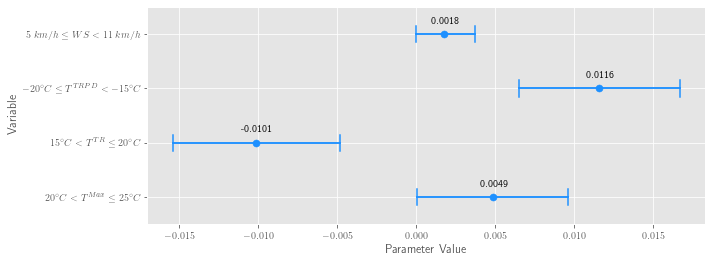

In [404]:
%matplotlib inline

plt.rcParams['text.usetex'] = True

plt.style.use('ggplot')

fig = plt.gcf()
fig.set_size_inches(10, 4)
ax = plt.axes()
for i, (index, row) in enumerate(results_stat_sign.iterrows()):
    if index == 'const':
        continue
    ax.scatter([row['Parameter']], [i], s=50, c='dodgerblue')#, linewidth=1,  edgecolors='dodgerblue')
    ax.plot([row['Lower CI'], row['Upper CI']], [i, i], color='dodgerblue')
    ax.plot([row['Lower CI'], row['Upper CI']], [i, i], color='dodgerblue')
    ax.plot([row['Lower CI'], row['Lower CI']], [i+0.15, i-0.15], color='dodgerblue')
    ax.plot([row['Upper CI'], row['Upper CI']], [i+0.15, i-0.15], color='dodgerblue')
    ax.annotate("{:.4f}".format(row['Parameter']), (row['Parameter'], i+0.2), ha='center')
plt.xlabel('Parameter Value')
plt.ylabel('Variable')
plt.yticks([i for i in range(0, len(results_stat_sign))], labels)
plt.ylim(0.5, len(labels)-0.5)
fig.savefig('regression_params.png', dpi=180, bbox_inches='tight')
plt.show()

In [426]:
df_visualise = df_ru_sample_agg_50.copy().reset_index()
df_visualise = df_visualise[df_visualise['city_int']==le3.transform(['Moscow'])[0]]
df_visualise['d'] = [datetime.strptime(d, '%Y-%m-%d') for d in df_visualise['date']]
df_visualise = df_visualise.set_index('d')

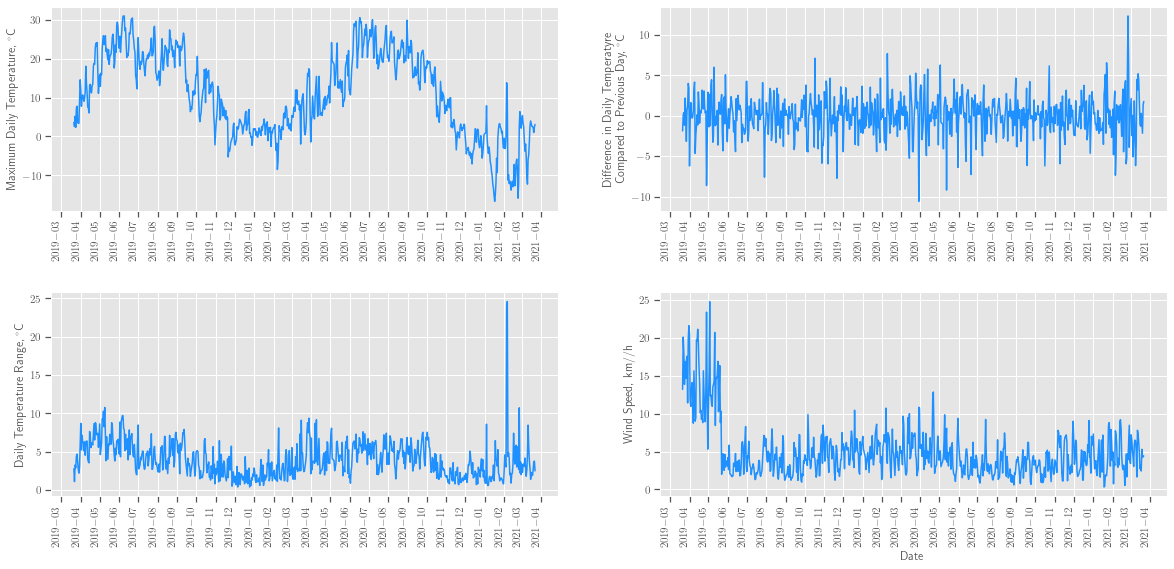

In [434]:
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4)
locator = mdates.MonthLocator()

ax1 = df_visualise[('tmax', 'mean')].plot(ax=axes[0, 0], color='dodgerblue')
ax1.set_ylabel("Maximum Daily Temperature, $^\circ$C")
ax1.set_xlabel("")
ax1.legend().remove()
ax1.xaxis.set_major_locator(locator)
ax1.tick_params(axis='x', labelrotation = 90)

ax2 = df_visualise['tavg_day_diff'].plot(ax=axes[0, 1], color='dodgerblue')
ax2.set_ylabel("Difference in Daily Temperatyre\nCompared to Previous Day, $^\circ$C")
ax2.set_xlabel("")
ax2.legend().remove()
ax2.xaxis.set_major_locator(locator)
ax2.tick_params(axis='x', labelrotation = 90)

ax3 = df_visualise['max_diff'].plot(ax=axes[1, 0], color='dodgerblue')
ax3.set_ylabel("Daily Temperature Range, $^\circ$C")
ax3.set_xlabel("")
ax3.legend().remove()
ax3.xaxis.set_major_locator(locator)
ax3.tick_params(axis='x', labelrotation = 90)

ax4 = df_visualise[('wspd', 'mean')].plot(ax=axes[1, 1], color='dodgerblue')
ax4.set_ylabel("Wind Speed, km//h")
ax4.set_xlabel("")
ax4.legend().remove()
ax4.xaxis.set_major_locator(locator)
ax4.tick_params(axis='x', labelrotation = 90)

plt.xlabel('Date')

plt.show()
fig.savefig('weather_moscow.png', dpi=180, bbox_inches='tight')

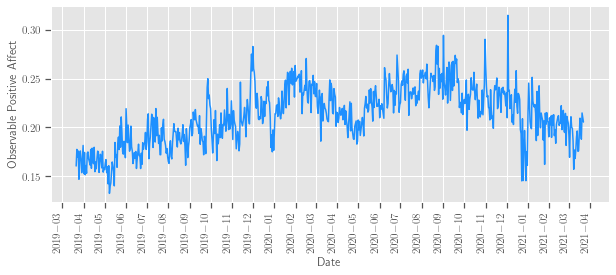

In [430]:
fig = plt.gcf()
fig.set_size_inches(10, 4)

ax = df_visualise['y'].plot(color='dodgerblue')
ax.set_ylabel("Observable Positive Affect")
ax.set_xlabel("Date")
ax.legend().remove()
ax.xaxis.set_major_locator(locator)
ax.tick_params(axis='x', labelrotation = 90)
plt.show()
fig.savefig('oswb_pa_moscow.png', dpi=180, bbox_inches='tight')
